## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_recall_curve
from time import process_time
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_curve, roc_auc_score
%matplotlib inline

## 1.1 Прочитаем файл application_train.csv и посмотрим как распределены классы целевой переменной.

<Axes: xlabel='TARGET', ylabel='Count'>

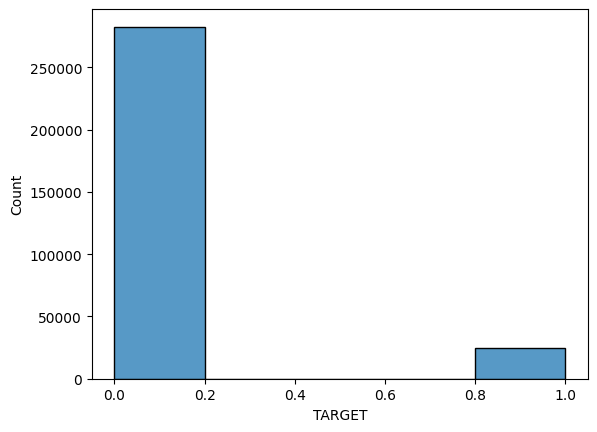

In [136]:
X = pd.read_csv('application_train.csv')

sns.histplot(X["TARGET"], binwidth=0.2)

Классы целевой переменной распределены неравномерно. Следовательно, модели могут плохо обучиться и показать плохую метрику на контрольной выборке.

## 1.2 Почистим выборку от пропущенных значений с помощью функции transform_data

In [137]:
def transform_data(data):
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_features] = data[numeric_features].fillna(0)

    categorical_features = data.select_dtypes(include=['object']).columns
    data[categorical_features] = data[categorical_features].fillna('nan')
    return data

In [138]:
X = transform_data(X)
X.isna().sum()
col_with_nan = X.isna().sum()
col_with_nan = col_with_nan[col_with_nan != 0]
col_with_nan

Series([], dtype: int64)

In [139]:
y = X['TARGET']
X = X.drop(['TARGET', 'SK_ID_CURR'], axis=1)
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.3 Разделим выборку на категориальные и вещественные признаки

In [140]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

index = X.select_dtypes(include=['float64', 'int64']).columns
numeric = X[index]
index = X.select_dtypes(include=['category']).columns
categorical = X[index]

__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [209]:
X_train, X_test, y_train, y_test = train_test_split(numeric, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(215257, 104) (92254, 104)


In [210]:
def model_scoring(clf, X_train, X_test, y_train, y_test): #Функция для вывода метрики и времени обучения

    start = process_time()
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)

    stop = process_time()
    time = stop - start
    pr= average_precision_score(y_test, y_proba[:, 1])
    print(f'Time: {time}\nPR: {pr}')

    return pr, y_proba[:, 1]

def graph_pr(y_test, y_lgbm, y_cat, pr_lgbm, pr_cat): #функция для вывода графиков precosion-recall
    precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_lgbm)
    precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_cat)

    plt.plot(recall_lgbm, precision_lgbm, label=(f'PR LightGBM = {pr_lgbm}'))
    plt.plot(recall_cat, precision_cat, label=(f'PR CatBoost = {pr_cat}'))
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.show()

## 2.1 Обучим модели LightGBM и CatBoost на вещественных признаках и посмотрим точность модели на контрольной выборке. В качестве метрики будем использовать площадь под кривой precision-recall (average_precision_score).

In [212]:
print('LGBM\n')
lgbm = LGBMClassifier(verbose=-100)
pr_lgbm, lgbm_proba = model_scoring(lgbm, X_train, X_test, y_train, y_test)

print('\nCatBoost\n')
cat = CatBoostClassifier(verbose=False)
pr_cat, cat_proba = model_scoring(cat, X_train, X_test, y_train, y_test)

LGBM

Time: 12.28125
PR: 0.23159230793933594

CatBoost

Time: 79.4375
PR: 0.23259848653401144


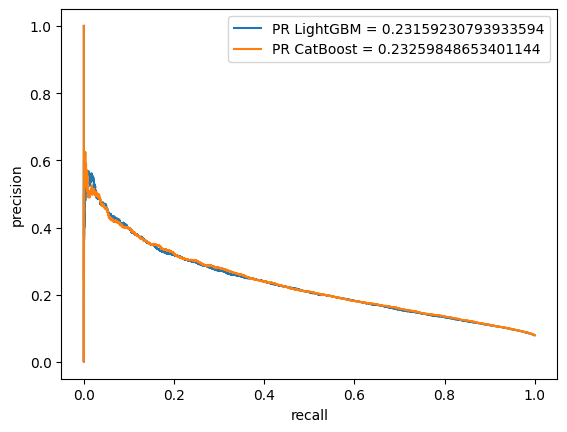

In [213]:
graph_pr(y_test, lgbm_proba, cat_proba, pr_lgbm, pr_cat)

Как видно, обе модели имеют примерно одинаковую точность на контрольной выборке.

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [214]:
from sklearn.model_selection import GridSearchCV

pr = [[0, 0, 0, 0],
      [0, 0, 0, 0]]

def best_params(clf, X_train, y_train, params): #Функция для подбора лучших параметров
    start = process_time()

    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    gridsearch = GridSearchCV(lgbm, param_grid=params, scoring='average_precision', cv=cv)
    gridsearch.fit(X_train, y_train)

    stop = process_time()
    print(f'Best parametrs: {gridsearch.best_params_}\ntime:{stop - start}')

    return gridsearch.best_params_

## 2.2 Найдем лучшие параметры для моделей, используя GridsearchCV. Посчитаем точность моделей на контрольной выборке, используя лучшие параметры.

In [30]:
lgbm_params = {'max_depth' : [2, 4, 6],
         'n_estimators' : [1000, 1500, 2000],
          'learning_rate': [0.01, 0.1, 0.5],
          'objective' : ['binary']}

lgbm = LGBMClassifier(verbose=-100)
lgbm__real_best = best_params(lgbm, X_train, y_train, lgbm_params)

Best parametrs: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'objective': 'binary'}
time:5279.21875


In [215]:
lgbm = LGBMClassifier(verbose=-100,
                      learning_rate=lgbm__real_best.get('learning_rate'),
                      max_depth=lgbm__real_best.get('max_depth'),
                      n_estimators=lgbm__real_best.get('n_estimators'),
                      objective=lgbm__real_best.get('objective'))

pr[0][0], lgbm_proba = model_scoring(lgbm, X_train, X_test, y_train, y_test)

Time: 35.4375
PR: 0.2334494228307752


In [32]:
cat_params = {'depth' : [2, 4, 6],
              'iterations' : [100, 200, 300],
              'learning_rate': [0.1, 0.5, 1],
              'loss_function' : ['Logloss', 'CrossEntropy']
              }

cat = CatBoostClassifier(verbose=False)
cat__real_best = best_params(cat, X_train, y_train, cat_params)

Best parametrs: {'depth': 2, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
time:5761.0


In [216]:
cat = CatBoostClassifier(verbose=False,
                         depth=cat__real_best.get('depth'),
                         iterations=cat__real_best.get('iterations'),
                         learning_rate=cat__real_best.get('learning_rate'),
                         loss_function=cat__real_best.get('loss_function'))

pr[1][0], cat_proba = model_scoring(cat, X_train, X_test, y_train, y_test)

Time: 5.328125
PR: 0.2153814769024524


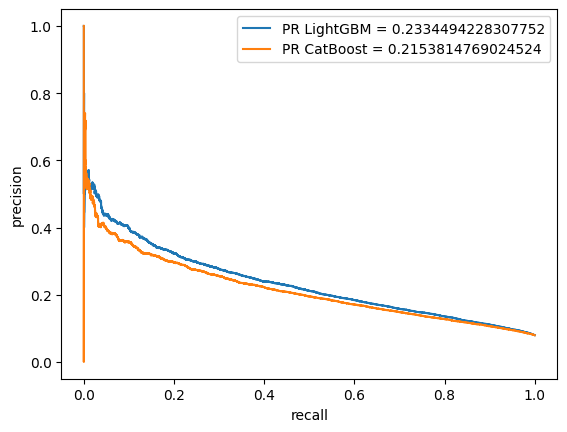

In [217]:
graph_pr(y_test, lgbm_proba, cat_proba, pr[0][0], pr[1][0])

In [219]:
cat = CatBoostClassifier(verbose=False,
                         depth=cat__real_best.get('depth'),
                         iterations=300,
                         learning_rate=cat__real_best.get('learning_rate'),
                         loss_function=cat__real_best.get('loss_function'))

pr_test, cat_proba_test = model_scoring(cat, X_train, X_test, y_train, y_test)

Time: 11.9375
PR: 0.22529022512484206


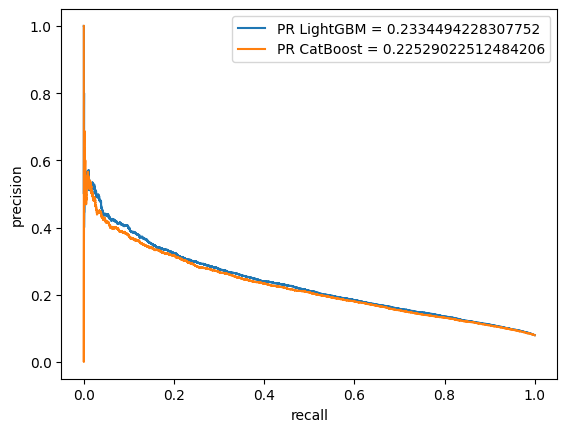

In [220]:
graph_pr(y_test, lgbm_proba, cat_proba_test, pr[0][0], pr_test)

Как видно, точность модели при увеличении количества деревьев выросла. Почему GridSearch подбирает минимальное колчиество деревьев из допустимых - мне непонятно.

У CatBoost при подстановке параметров из GridSearch немного падает точность. Скорее всего, происходит это из-за количества деревьев, которое подбирает GridSearch. При большем количестве деревьев, точность модели повышается. Можно увидеть это, если подставить в параметр 'iterations' вместо 100, которые выбрал GridSearch, 300.

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

## 3.1 С помощью get_dummies к категориальным признакам применим one-hot кодирование

In [193]:
cat_oh = pd.get_dummies(categorical)
df_with_cat = numeric.join(cat_oh)
df_with_cat.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,False,False,False,False,True,False,False,True,False,False
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,False,False,False,False,False,False,False,True,False,False
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,False,False,False,False,False,False,True,False,False,True
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,False,False,False,False,False,False,True,False,False,True
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,False,False,False,False,False,False,True,False,False,True


## 3.2 Теперь найдем лучшие параметры для выборки с вещественными признаками и категориальными, к котороым применили one-hot кодирование. Найдем точность моделей на контрольной выборке.

In [36]:
import re

df_with_cat = df_with_cat.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_train, X_test, y_train, y_test = train_test_split(df_with_cat, y, test_size=0.3, random_state=0)

In [37]:
lgbm = LGBMClassifier(verbose=-100)
lgbm_best = best_params(lgbm, X_train, y_train, lgbm_params)

Best parametrs: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'objective': 'binary'}
time:5245.890625


In [222]:
lgbm = LGBMClassifier(verbose=-100,
                      learning_rate=lgbm_best.get('learning_rate'),
                      max_depth=lgbm_best.get('max_depth'),
                      n_estimators=lgbm_best.get('n_estimators'),
                      objective=lgbm_best.get('objective'))

pr[0][1], lgbm_proba_oh = model_scoring(lgbm, X_train, X_test, y_train, y_test)

Time: 52.96875
PR: 0.2334494228307752


In [39]:
cat = CatBoostClassifier(verbose=False)
cat_best = best_params(cat, X_train, y_train, cat_params)

Best parametrs: {'depth': 2, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
time:5154.390625


In [223]:
cat = CatBoostClassifier(verbose=False,
                         depth=cat_best.get('depth'),
                         iterations=cat_best.get('iterations'),
                         learning_rate=cat_best.get('learning_rate'),
                         loss_function=cat_best.get('loss_function'))

pr[1][1], cat_proba_oh = model_scoring(cat, X_train, X_test, y_train, y_test)

Time: 5.65625
PR: 0.2153814769024524


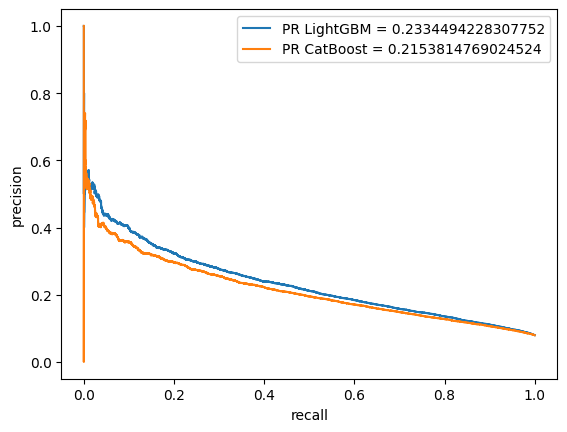

In [224]:
graph_pr(y_test, lgbm_proba_oh, cat_proba_oh, pr[0][1], pr[1][1])

## 3.3 Теперь для определения категориальных признаков будем использовать встроенные параметры моделей. В качестве параметров будем использовать параметры, найденные в пункте выше. Также посчитаем точность моделей.

In [226]:
cat_labels = np.array(categorical.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [227]:
lgbm = LGBMClassifier(verbose=-100, categorical_feature=cat_labels,
                      learning_rate=lgbm_best.get('learning_rate'),
                      max_depth=lgbm_best.get('max_depth'),
                      n_estimators=lgbm_best.get('n_estimators'),
                      objective='binary')

start = process_time()
lgbm.fit(X_train, y_train)
lgbm_proba_cat = lgbm.predict_proba(X_test)

stop = process_time()
time = stop - start
pr[0][2]= average_precision_score(y_test, lgbm_proba_cat[:, 1])
print(f'Time: {time}\nPR: {pr[0][2]}')

C:\Users\switc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\switc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Time: 43.84375
PR: 0.2376851926221542


In [228]:
cat = CatBoostClassifier(verbose=False,
                         depth=cat_best.get('depth'),
                         iterations=cat_best.get('iterations'),
                         learning_rate=cat_best.get('learning_rate'),
                         loss_function=cat_best.get('loss_function'))

start = process_time()
cat.fit(X_train, y_train, cat_features=cat_labels)
cat_proba_cat = cat.predict_proba(X_test)

stop = process_time()
time = stop - start
pr[1][2]= average_precision_score(y_test, cat_proba_cat[:, 1])
print(f'Time: {time}\nPR: {pr[1][2]}')

Time: 21.28125
PR: 0.21942040470098678


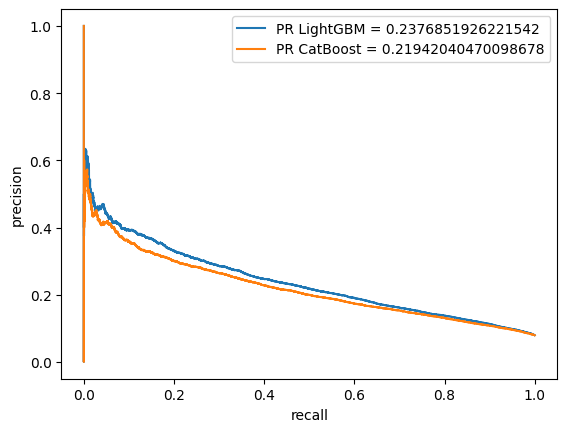

In [230]:
graph_pr(y_test, lgbm_proba_cat[:,1], cat_proba_cat[:,1], pr[0][2], pr[1][2])

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

## 5.1 Найдем среднее значение y_proba из тех значений, которые мы нашли в пунктах 2.2, 3.2 и 3.3. Также посчитаем точность среднего значения и запишем все результаты в таблицу.

In [202]:
lgbm_y = (lgbm_proba + lgbm_proba_oh + lgbm_proba_cat[:,1])/3
cat_y = (cat_proba + cat_proba_oh + cat_proba_cat[:,1])/3

pr[0][3] = average_precision_score(y_test, lgbm_y)
pr[1][3] = average_precision_score(y_test, cat_y)

total_scor = pd.DataFrame(index = ['LightGBM','CatBoost'],
                         columns = ['real', 'real + ohe',
                                    'real + cat', 'blending'])
for i in range(2):
    for j in range(4):
        total_scor.iloc[i, j] = pr[i][j]

total_scor

,real,real + ohe,real + cat,blending
LightGBM,0.231869,0.240097,0.237685,0.239852
CatBoost,0.215091,0.218443,0.21942,0.219371


Можно заметить, что обе модели показывают худшую точность на выборке с только вещественными признаками. Также обе модели показали хорошие результаты, при использовании встроенных параметров для определения категориальных признаков.

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

## 6.1 Определим важность вещественных признаков для модели LightGBM с помощью аттрибута feature_importance_. Отсортируем признаки по важности и визуализируем их.

In [231]:
X_train, X_test, y_train, y_test = train_test_split(numeric, y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Features Lightgbm')

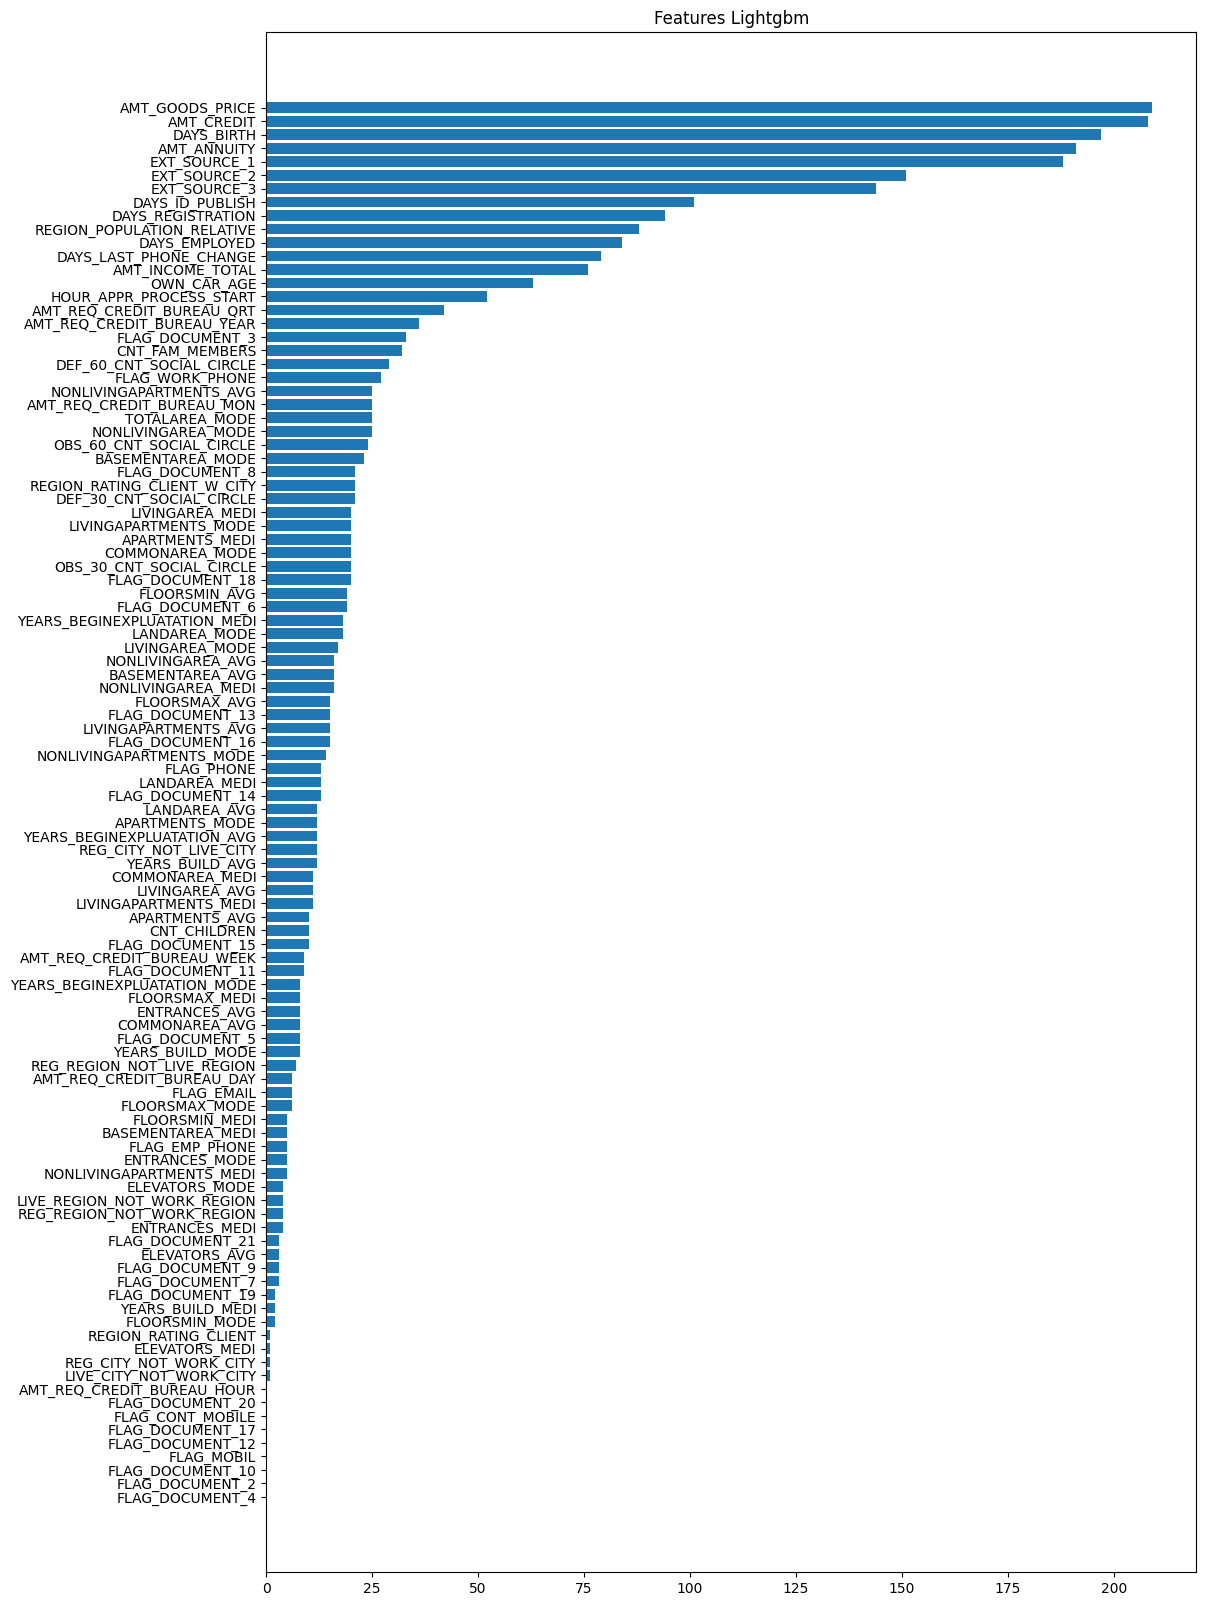

In [232]:
lgbm = LGBMClassifier(verbose=-100,
                      learning_rate=lgbm__real_best.get('learning_rate'),
                      max_depth=lgbm__real_best.get('max_depth'),
                      n_estimators=lgbm__real_best.get('n_estimators'),
                      objective=lgbm__real_best.get('objective'))

lgbm.fit(X_train, y_train)

important_features_lgbm = lgbm.feature_importances_
index = np.argsort(important_features_lgbm)
important_features_lgbm = important_features_lgbm[index]
features_lgbm_labels = np.array(numeric.columns[index])

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(index)), important_features_lgbm, align='center')
plt.yticks(range(len(index)), features_lgbm_labels)
plt.title('Features Lightgbm')

## Возьмем первые 24 признака и посчитаем точность LightGBM только на этих признаках

In [233]:
features_lgbm_labels = features_lgbm_labels[80:]
print(f'count of important features for lightgbm: {len(np.array(features_lgbm_labels))}')

count of important features for lightgbm: 24


In [234]:
X_imp = numeric[features_lgbm_labels]

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=0)

In [235]:
start = process_time()
lgbm.fit(X_train, y_train)
lgbm_proba = lgbm.predict_proba(X_test)

stop = process_time()
time = stop - start
pr_lgbm = average_precision_score(y_test, lgbm_proba[:, 1])
print(f'Time: {time}\nPR: {pr_lgbm}')

Time: 24.796875
PR: 0.23408535317453655


## 6.2 Теперь определим важность вещественных признаков для модели CatBoost также с помощью аттрибута feature_importance_. Отсортируем признаки по важности и визуализируем их.

In [236]:
X_train, X_test, y_train, y_test = train_test_split(numeric, y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Features Lightgbm')

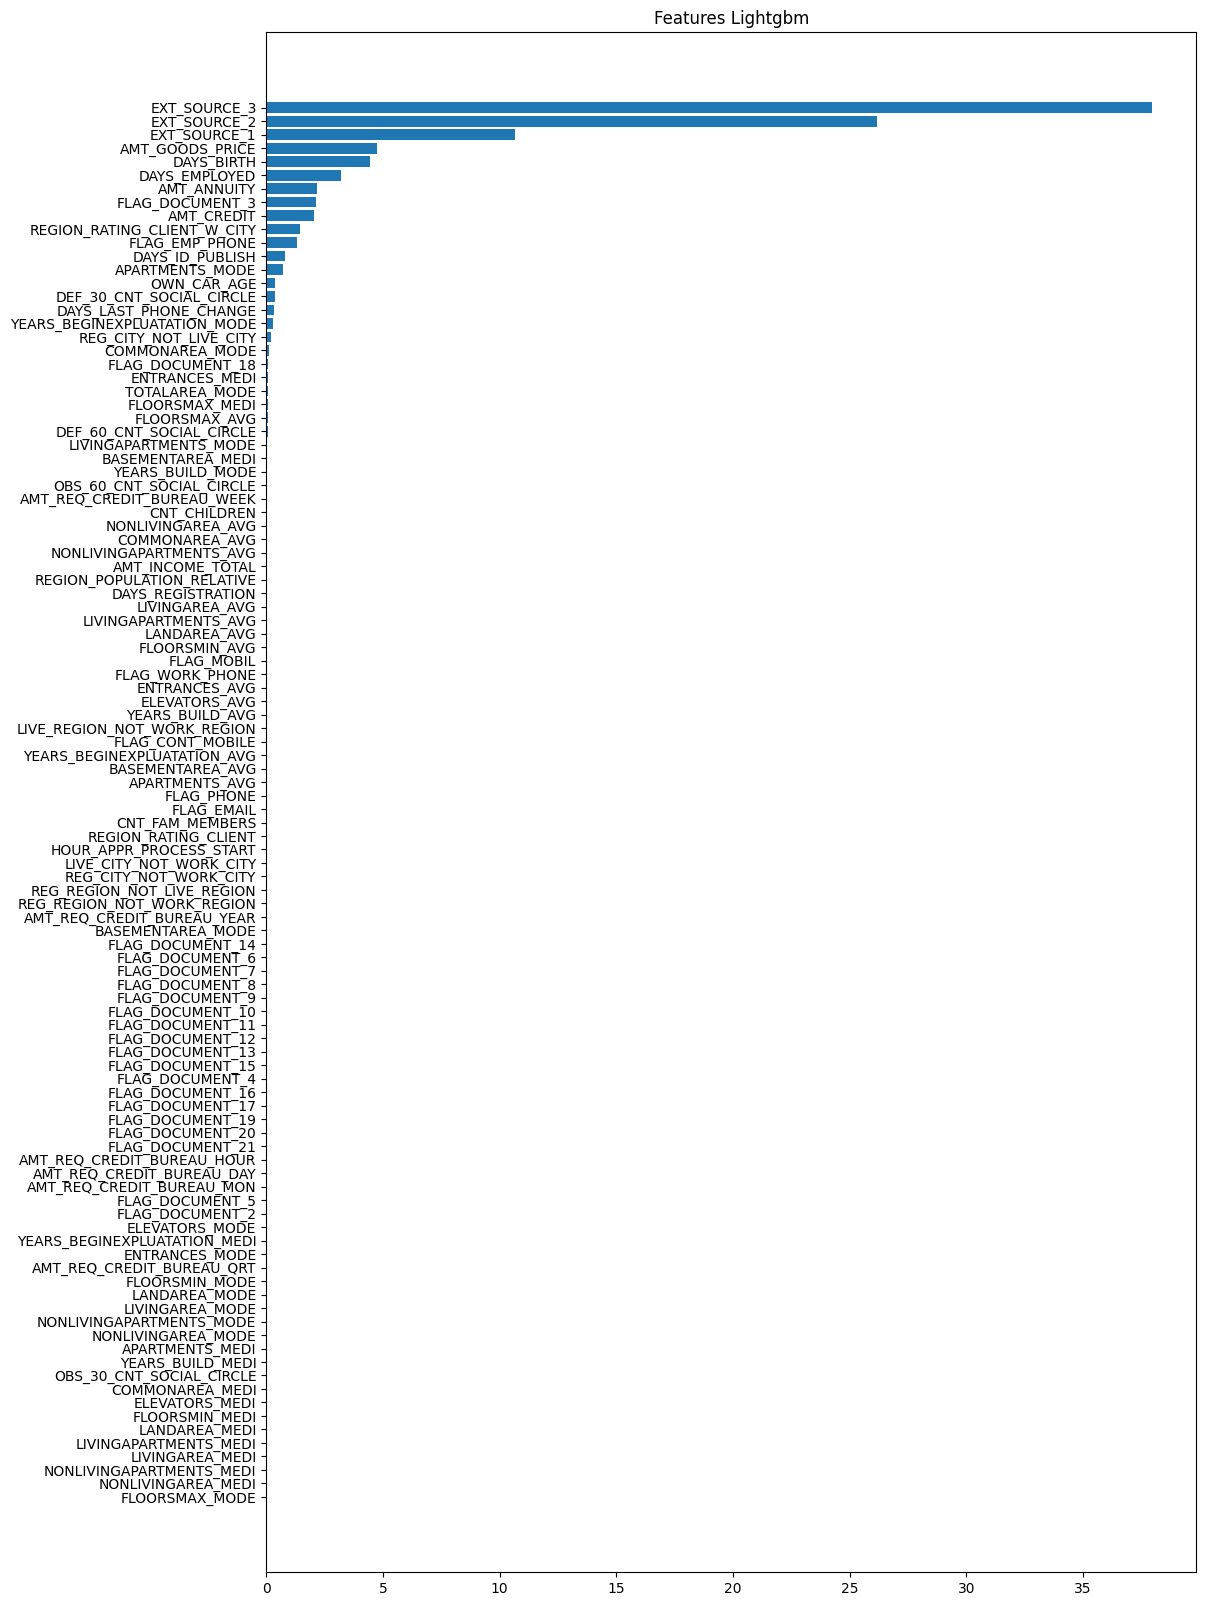

In [237]:
cat = CatBoostClassifier(verbose=False,
                         depth=cat__real_best.get('depth'),
                         iterations=cat__real_best.get('iterations'),
                         learning_rate=cat__real_best.get('learning_rate'),
                         loss_function=cat__real_best.get('loss_function'))

cat.fit(X_train, y_train)

important_features_cat = cat.feature_importances_
index = np.argsort(important_features_cat)
important_features_cat = important_features_cat[index]
features_cat_labels = np.array(numeric.columns[index])

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(index)), important_features_cat, align='center')
plt.yticks(range(len(index)), features_cat_labels)
plt.title('Features Lightgbm')

## Возьмем также первые 24 признака и посчитаем точность модели на них.

In [238]:
features_cat_labels = features_cat_labels[80:]
print(f'count of important features for lightgbm: {len(np.array(features_cat_labels))}')

count of important features for lightgbm: 24


In [239]:
X_imp = numeric[features_cat_labels]

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=0)

In [240]:
cat = CatBoostClassifier(verbose=False,
                         depth=cat__real_best.get('depth'),
                         iterations=cat__real_best.get('iterations'),
                         learning_rate=cat__real_best.get('learning_rate'),
                         loss_function=cat__real_best.get('loss_function'))

start = process_time()
cat.fit(X_train, y_train)
cat_proba = cat.predict_proba(X_test)

stop = process_time()
time = stop - start
pr_cat = average_precision_score(y_test, cat_proba[:, 1])
print(f'Time: {time}\nPR: {pr_cat}')

Time: 2.953125
PR: 0.21509113695749355


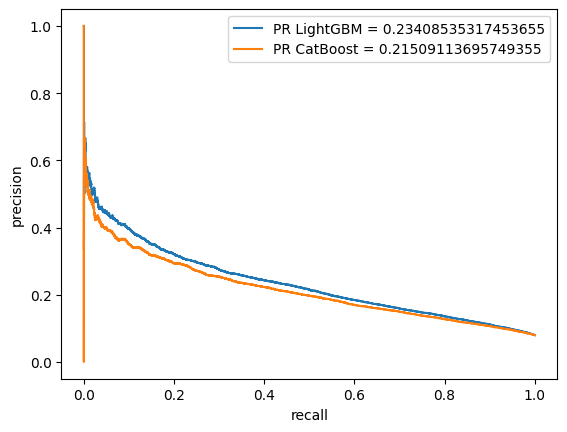

In [241]:
graph_pr(y_test, lgbm_proba[:,1], cat_proba[:,1], pr_lgbm, pr_cat)

## Запишем в таблицу точность моделей на выборке со всеми вещественными признаками и на выборке с только важными признаками.

In [242]:
tab = pd.DataFrame(index = ['LightGBM','CatBoost'],
                   columns = ['all_features', 'important_features'])

tab.iloc[0, 0] = pr[0][0]
tab.iloc[0, 1] = pr_lgbm
tab.iloc[1, 0] = pr[1][0]
tab.iloc[1, 1] = pr_cat

tab

,all_features,important_features
LightGBM,0.233449,0.234085
CatBoost,0.215381,0.215091


Качество моделей незначительно изменилось.